# Llama 3 + E2B Code interpreter        
**Powered by open-source [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**

E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker).

Inside this sandbox is a running Jupyter server that the LLM can use.

In [1]:
%pip install together e2b_code_interpreter

In [17]:
# TODO: Get your Together AI API key from https://together.ai
TOGETHER_API_KEY = ""

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = ""

# Or use 8b version
# MODEL_NAME = "meta-llama/llama-3-8b-chat-hf"
MODEL_NAME = "meta-llama/llama-3-70b-chat-hf"

SYSTEM_PROMPT = """you are a python data scientist. you are given tasks to complete and you run python code to solve them.
  - DO NOT RESPOND WITH ANYTHING ELSE BUT PYTHON CODE
  - DO NOT FORGET ANY IMPORTS LIKE `import numpy as np`
  - the python code runs in jupyter notebook.
  - every time you generate code, it's executed in a separate cell in jupyter notebook.
  - display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
  - you have access to the internet and can make api requests.
  - you also have access to the filesystem and can read/write files.
  - you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
  - you can run any python code you want, everything is running in a secure sandbox environment."""

In [12]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [26]:
import os
import json
import re
from together import Together

client = Together(api_key=TOGETHER_API_KEY)

def match_code_blocks(text):
    pattern = re.compile(r'```(?:python)?[\n\r](.*?)```', re.DOTALL)
    return pattern.findall(text)

def chat_with_llama(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
  )

  content = response.choices[0].message.content
  print(f"\nLlama 3 Response:\n{content}")
  print("===")

  code_results = []
  code_blocks = match_code_blocks(content)
  for code in code_blocks:
    print(f"Code to run: {code}")

    code_interpreter_results = code_interpret(e2b_code_interpreter, code)
    print(f"Tool Result: {code_interpreter_results}")
    code_results.append(code_interpreter_results)

  return code_results




User Message: Calculate value of pi using monte carlo method. Use 1000 iterations. Visualize all points of all iterations on a single plot, a point inside the unit circle should be green, other points should be gray.

Llama 3 Response:
```
import numpy as np
import matplotlib.pyplot as plt

# Number of iterations
n = 1000

# Generate random points
x = np.random.rand(n)
y = np.random.rand(n)

# Calculate distance from origin
dist = x**2 + y**2

# Check if points are inside the unit circle
inside_circle = dist <= 1

# Calculate pi
pi_estimate = np.sum(inside_circle) / n * 4
print("Estimated value of pi:", pi_estimate)

# Visualize points
plt.figure(figsize=(6, 6))
plt.scatter(x[inside_circle], y[inside_circle], color='green', alpha=0.5)
plt.scatter(x[~inside_circle], y[~inside_circle], color='gray', alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Monte Carlo Estimation of Pi")
plt.show()
```
===
Code to run: import numpy as np
import m

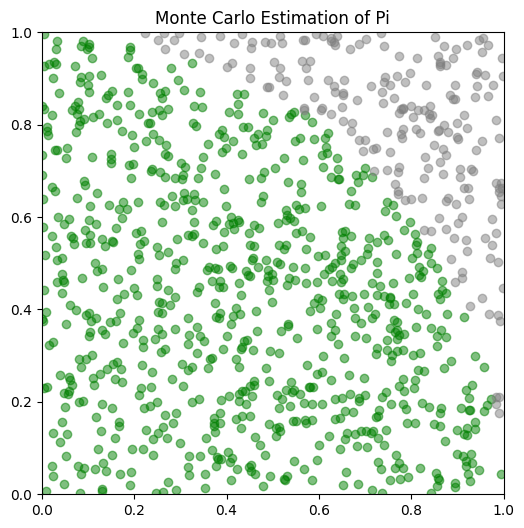

In [28]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=E2B_API_KEY) as code_interpreter:
  all_code_blocks_results = chat_with_llama(
    code_interpreter,
    "Calculate value of pi using monte carlo method. Use 1000 iterations. Visualize all points of all iterations on a single plot, a point inside the unit circle should be green, other points should be gray.",
  )
  for result in all_code_blocks_results:
    print(result[0])

# Each code block can have multiple code interpreter results
first_result = all_code_blocks_results[0][0]

# This will render the image
# You can also access the data directly
# first_result.png
# first_result.jpg
# first_result.pdf
# ...
first_result